# Importing Data From Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreenathbharadwaj","key":"fccb0c56b4918e6e6341fa01273bbece"}'}

In [2]:
! mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!pip install kaggle

In [4]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge             COVID-19 Open Research Dataset Challenge (CORD-19)    4GB  2020-07-17 15:05:34          89294  
roche-data-science-coalition/uncover                          UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          15773  
oleksastepaniuk/prozorro-public-procurement-dataset           ProZorro. Ukrainian public procurement dataset      448MB  2020-04-15 17:09:37             82  
navinmundhra/daily-power-generation-in-india-20172020         Daily Power Generation in India (2017-2020)          63KB  2020-06-29 17:13:29           1007  
parulpandey/covid19-clinical-trials-dataset         

In [5]:
!kaggle competitions download -c Sentiment-Analysis-of-tweets

  0% 0.00/714k [00:00<?, ?B/s]
100% 714k/714k [00:00<00:00, 99.4MB/s]
  0% 0.00/1.36M [00:00<?, ?B/s]
100% 1.36M/1.36M [00:00<00:00, 91.7MB/s]


In [6]:
!unzip /content/train.txt.zip

Archive:  /content/train.txt.zip
  inflating: train.txt               


# Installing Requirements

In [7]:
!nvidia-smi

Sun Jul 19 07:33:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 33kB/s 


In [9]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.30.0)


In [10]:
!pip install tqdm

In [11]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=d8b8b0bb25df7c73f83bebcbbfcd3d7e3adfde69fcdeb9aa02dd4933b73c9edc
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=cea4bac1851a0271be2c673d5ef0d33ee5281f05f226022cf873c221ac4eeabb
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=0c1eb5ef7fc0a487f9fe09e44bbb6dd6da61cb176eabf443e3fae126825835f5
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [12]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 3.4MB/s 


# Importing Libraries

In [14]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)



rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Visulisation

In [15]:
train = pd.read_csv("/content/train.txt")
test = pd.read_csv("/content/test_samples.txt")

In [16]:
train.head()

,tweet_id,sentiment,tweet_text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [17]:
train.shape

(21465, 3)

In [18]:
train.describe()

,tweet_id
count,2.146500e+04
mean,4.084325e+17
std,1.992714e+17
min,9.083248e+16
25%,2.587897e+17
50%,2.642246e+17
75%,6.360488e+17
max,6.416760e+17


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    21465 non-null  int64 
 1   sentiment   21465 non-null  object
 2   tweet_text  21465 non-null  object
dtypes: int64(1), object(2)
memory usage: 503.2+ KB


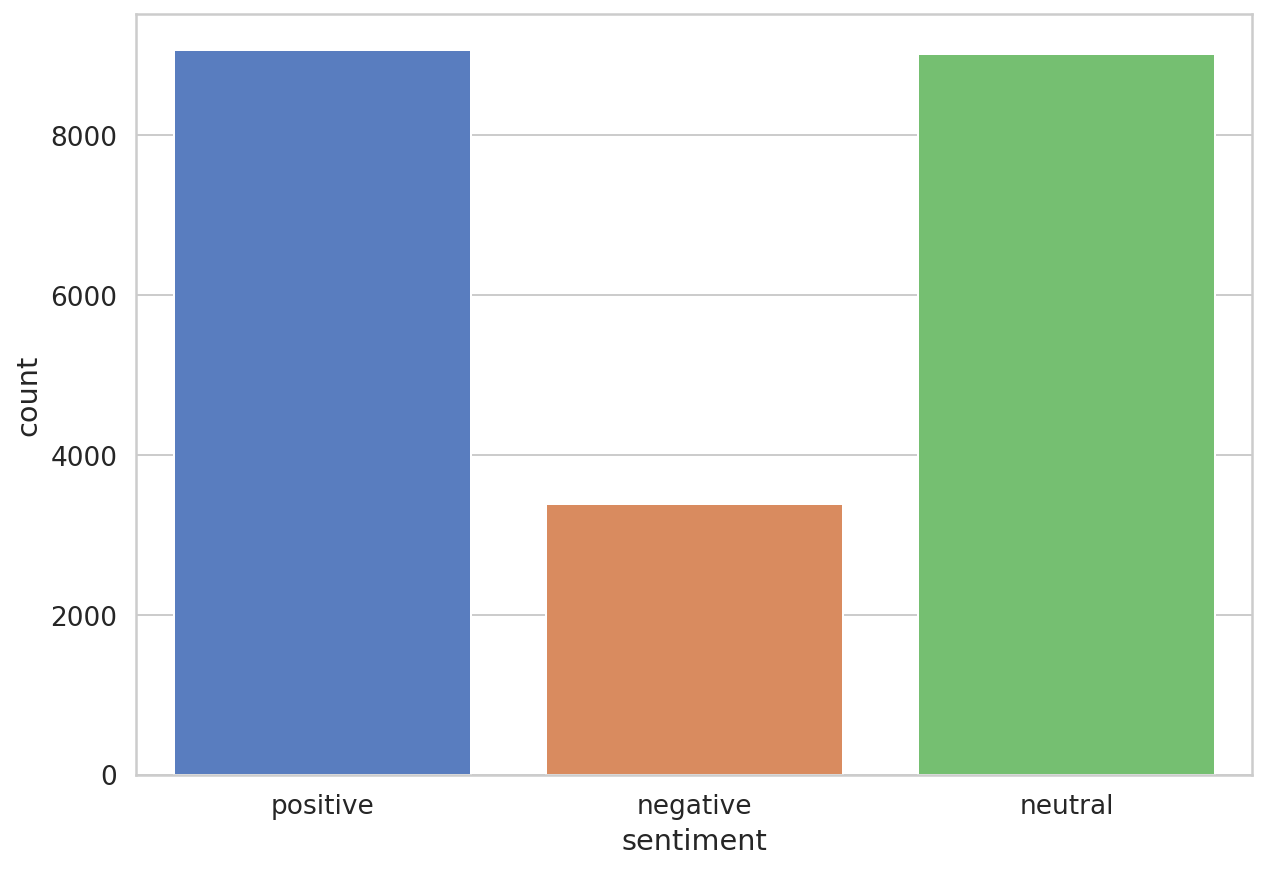

In [21]:
plt.figure(figsize = (10, 7))
sns.countplot(data = train, x = 'sentiment')

In [22]:
train.sentiment.value_counts()

positive    9064
neutral     9014
negative    3387
Name: sentiment, dtype: int64

In [23]:
test['sentiment'] = "positive"

# importing BERT pretrained model

In [24]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-07-19 07:47:02--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  33.3MB/s    in 13s     

2020-07-19 07:47:15 (31.1 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [25]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [26]:
os.makedirs("model", exist_ok=True)

In [27]:
!mv uncased_L-12_H-768_A-12/ model

In [28]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

# Data Preprocessing

In [29]:
class SentimentAnalysisData:
  DATA_COLUMN = "tweet_text"
  LABEL_COLUMN = "sentiment"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[SentimentAnalysisData.DATA_COLUMN], row[SentimentAnalysisData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

# Creating Bert model

In [30]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [31]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)
  
  print("bert shape", bert_output.shape)
  #cls_out = keras.layers.SpatialDropout1D(0.3)(bert_output)
  #cls_out = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(bert_output)
  #cls_out = keras.layers.SpatialDropout1D(0.5)(cls_out)
  #cls_out = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(cls_out)
  #cls_out = keras.layers.concatenate([keras.layers.GlobalMaxPooling1D()(cls_out),keras.layers.GlobalAveragePooling1D()(cls_out),])
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)

  

  cls_out = keras.layers.Dropout(0.5)(cls_out)
  #cls_out = keras.layers.Flatten()(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  #logits = keras.layers.Dense(units=512, activation="tanh")(cls_out)
  #logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [32]:
classes = train.sentiment.unique().tolist()

data = SentimentAnalysisData(train, test, tokenizer, classes, max_seq_len=128)

21465it [00:09, 2177.26it/s]
5398it [00:02, 2226.61it/s]


max seq_len 2309


In [33]:
classes

['positive', 'negative', 'neutral']

In [34]:
data.train_x.shape

(21465, 128)

In [35]:
data.train_x[0]

array([  101,  3806,  2011,  2026,  2160,  2718,  1002,  1017,  1012,
        4464,   999,   999,   999,   999,  1045,  1032, 23343, 24096,
        2683,  2213,  2183,  2000,  4970,  2940,  2006,  2938,  1012,
        1024,  1007,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [36]:
data.train_y[0]

0

In [37]:
data.max_seq_len

128

In [42]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f142369bfd0> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [43]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 2307

# Training model

In [44]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [45]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=epochs,
)

Epoch 1/3
1208/1208 [==============================] - 550s 455ms/step - loss: 0.9507 - acc: 0.5787 - val_loss: 0.8597 - val_acc: 0.6865
Epoch 2/3
1208/1208 [==============================] - 547s 453ms/step - loss: 0.8509 - acc: 0.6902 - val_loss: 0.8064 - val_acc: 0.7317
Epoch 3/3
1208/1208 [==============================] - 547s 453ms/step - loss: 0.8058 - acc: 0.7398 - val_loss: 0.8307 - val_acc: 0.7108


# model evluation

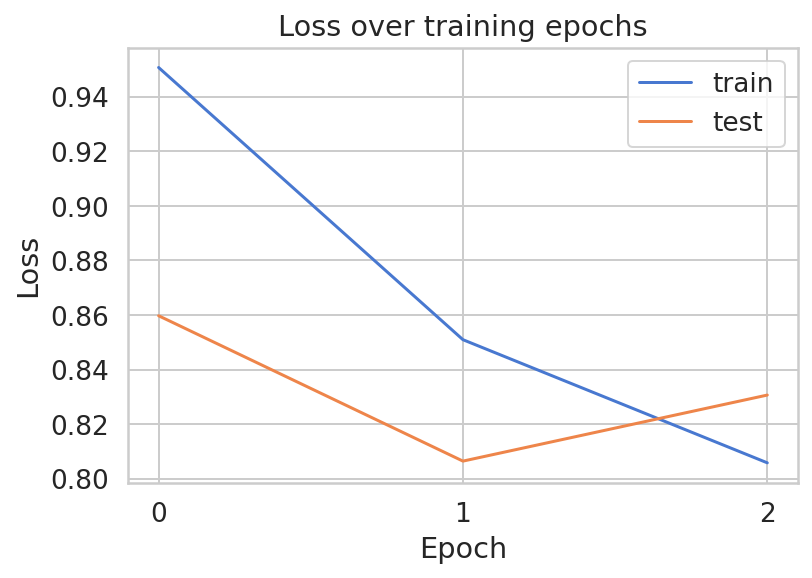

In [46]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

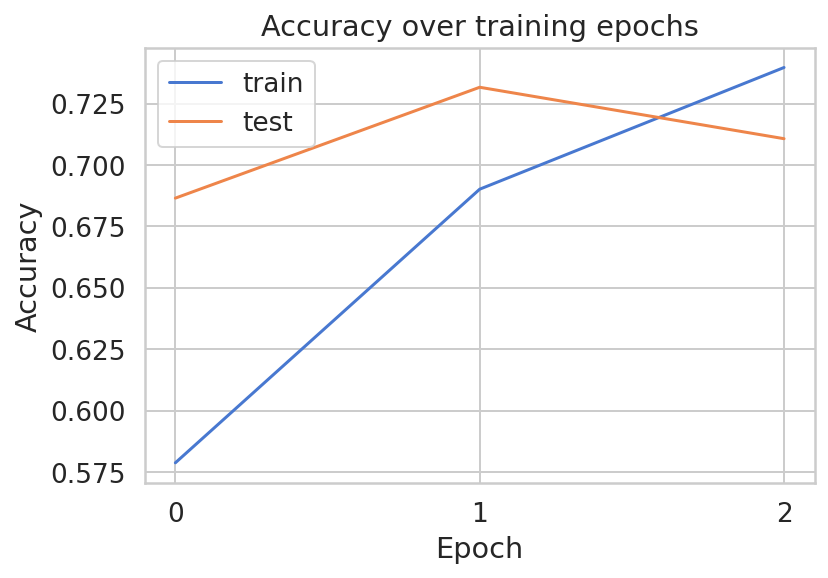

In [47]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

# prediction

In [48]:
y_pred = model.predict(data.test_x).argmax(axis=1)

In [49]:
y_pred.shape

(5398,)

In [50]:
predictions = []
for i in range(len(y_pred)):
  predictions.append(classes[y_pred[i]])

predictions = np.array(predictions)

# Submission

In [51]:
submissions = pd.DataFrame({"tweet_id": test['tweet_id'],
    "sentiment": predictions})
submissions.to_csv("my_submission.csv", index=False, header=True)

In [52]:
submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5398 non-null   int64 
 1   sentiment  5398 non-null   object
dtypes: int64(1), object(1)
memory usage: 84.5+ KB


In [53]:
submissions['sentiment'].describe()

count        5398
unique          3
top       neutral
freq         2354
Name: sentiment, dtype: object